In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image
import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

## Model copied from [Notebook](https://www.kaggle.com/code/brionymeng/keras-starter-kit-unet-train-on-full-dataset)

In [3]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    
    x = inputs
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# if USE_MIXED_PRECISION:
#     keras.mixed_precision.set_global_policy('mixed_float16')

# model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
# model.summary()
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], jit_compile=USE_JIT_COMPILE)

# model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)
# model.save("model.keras")

### Initialize Configuration Variables

In [4]:
PREFIX = '/home/sudolife/project/dataset/train/'
# BUFFER = 30  # Buffer size in x and y direction
# Z_START = 27  # First slice in the z direction to use
# Z_DIM = 10  # Number of slices in the z direction
# TRAINING_STEPS = 30000
LEARNING_RATE = 0.01
BATCH_SIZE = 16
TILE_SIZE = 128
EPOCH = 20
STRIDE = TILE_SIZE//2

## Train only on fragment_1

In [5]:
def read_1st_frag_slice_label_mask(slice_idx):
    
    fragment_id=1
    
    slices = []
    
    (x11,y11), (x12,y12),(x21,y21),(x22,y22)=[(650,3000),(4000,7500),(2300,400),(5000,2700)]
    
    # read ink labels as bool array
    label = np.array(Image.open(PREFIX + f"{fragment_id}/inklabels.png").convert('1'))

    # read mask.png as bool array
    mask = np.array(Image.open(PREFIX + f"{fragment_id}/mask.png").convert('1'))


    for i in tqdm(slice_idx):
        # shape of a slice of fragment 1: (8181, 6330)
        slice = cv2.imread(PREFIX + f"{fragment_id}/surface_volume/{i:02}.tif", 0)
        
        # Normalization
        slice = slice.astype('float32')
        slice /= 255.0
        
        slices.append(slice)

    slices = np.stack(slices, axis=0)
    
    # crop two main parts of the fragments
    slices_1 = slices[:, y11:y12, x11:x12]
    slices_2 = slices[:, y21:y22, x21:x22]
    label_1 = label[y11:y12, x11:x12]
    label_2 = label[y21:y22, x21:x22]
    mask_1 = mask[y11:y12, x11:x12]
    mask_2 = mask[y21:y22, x21:x22]
    

    return slices_1, slices_2,label_1,label_2,mask_1,mask_2,slices, label, mask

In [6]:
def get_train_test_dataset_of_frag_1(slice_idx):
    train_tiles = []
    train_labels = []

    test_tiles = []
    test_labels = []
    test_xyxys = []

    slices_1, slices_2,label_1,label_2,mask_1,mask_2,slices, label, mask = read_1st_frag_slice_label_mask(slice_idx)

    # crop out the tile on the edge of the slices
    x11_list = list(range(0, slices_1.shape[2] - TILE_SIZE + 1, STRIDE))
    y11_list = list(range(0, slices_1.shape[1] - TILE_SIZE + 1, STRIDE))

    for y1 in y11_list:
        for x1 in x11_list:
            y2 = y1 + TILE_SIZE
            x2 = x1 + TILE_SIZE

            # other fragments goes to training set,
            # tiles from different fragments are not separated
            train_tiles.append(slices_1[:, y1:y2, x1:x2])
            train_labels.append(label_1[y1:y2, x1:x2])


    x21_list = list(range(0, slices_2.shape[2] - TILE_SIZE + 1, STRIDE))
    y21_list = list(range(0, slices_2.shape[1] - TILE_SIZE + 1, STRIDE))

    for y1 in y21_list:
        for x1 in x21_list:
            y2 = y1 + TILE_SIZE
            x2 = x1 + TILE_SIZE
            # xyxys.append((x1, y1, x2, y2))

            # use the upper right part of fragment 1 for test
            test_tiles.append(slices_2[:, y1:y2, x1:x2])
            test_labels.append(label_2[y1:y2, x1:x2])

            test_xyxys.append([x1, y1, x2, y2])


    train_tiles = np.stack(train_tiles, axis=0)
    train_labels = np.stack(train_labels, axis=0)
    test_tiles = np.stack(test_tiles, axis=0)
    test_labels = np.stack(test_labels, axis=0)

    return train_tiles, train_labels, test_tiles, test_labels, test_xyxys

### Some visualization of the tiles (Skip to speed up)

100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


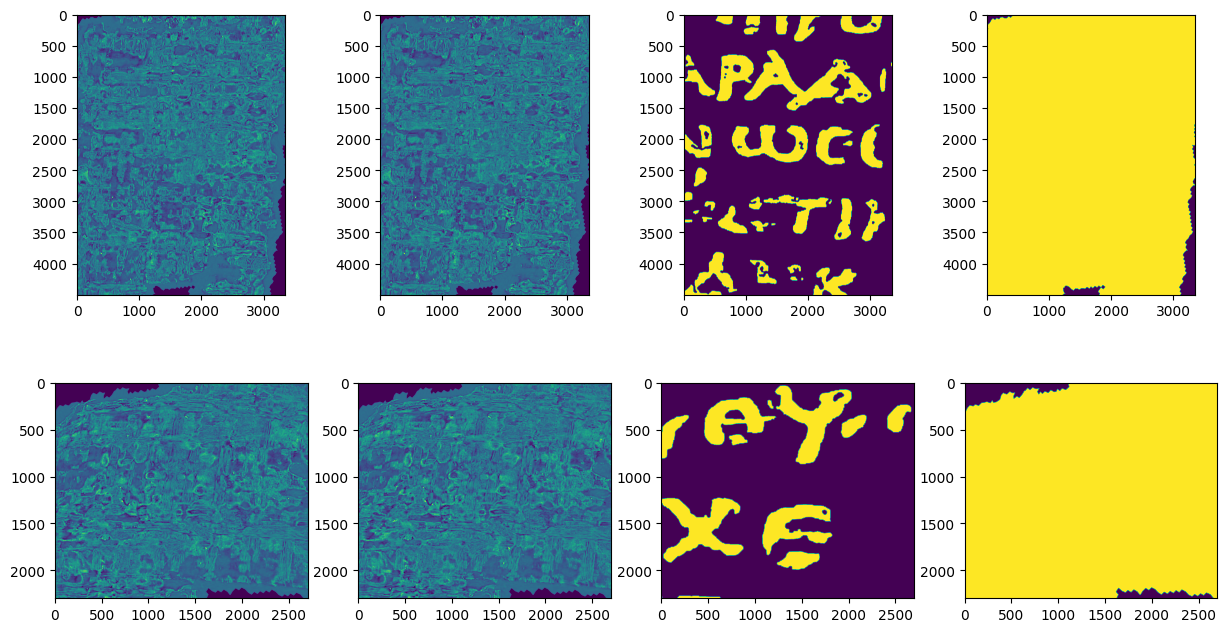

In [7]:
slices_1, slices_2,label_1,label_2,mask_1,mask_2,slices, label, mask = read_1st_frag_slice_label_mask([3,4])

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes[0,0].imshow(slices_1[0])
axes[0,1].imshow(slices_1[1])
axes[0,2].imshow(label_1)
axes[0,3].imshow(mask_1)
axes[1,0].imshow(slices_2[0])
axes[1,1].imshow(slices_2[1])
axes[1,2].imshow(label_2)
axes[1,3].imshow(mask_2)

plt.show()

##### get tiles from two main parts of fragment 1

In [8]:
train_tiles, train_labels, test_tiles, test_labels, _ = get_train_test_dataset_of_frag_1([3])

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


##### plot the labels of tiles

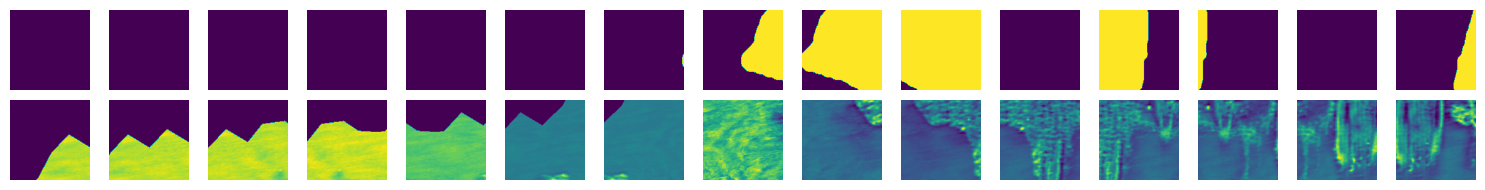

In [9]:
# np.random.seed(420)
# idx_train = np.random.randint(0,len(train_tiles),size=10)
# idx_test = np.random.randint(0,len(test_tiles),size=10)

# continuous samples
idx_train = np.arange(0,15)
idx_test = np.arange(0,15)

fig, axes = plt.subplots(2,15,figsize=(15,2))
for c,i in enumerate(idx_train):
    axes[0,c].imshow(train_labels[i])
# for c,i in enumerate(idx_test):
#     axes[1,c].imshow(test_labels[i])

for c,i in enumerate(idx_train):
    axes[1,c].imshow(train_tiles[i][0])

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

##### plot the tiles

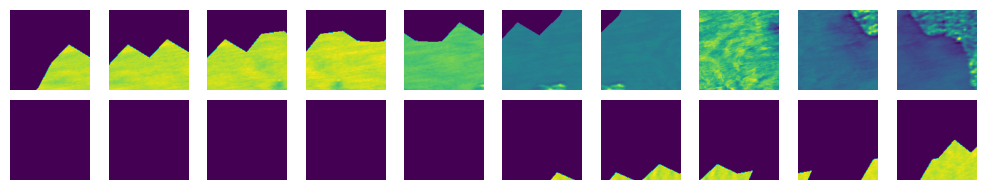

In [10]:
# np.random.seed(420)
# idx_train = np.random.randint(0,len(train_tiles),size=10)
# idx_test = np.random.randint(0,len(test_tiles),size=10)

# continuous samples
idx_train = np.arange(0,10)
idx_test = np.arange(0,10)

fig, axes = plt.subplots(2,10,figsize=(10,2))
for c,i in enumerate(idx_train):
    axes[0,c].imshow(train_tiles[i][0])
for c,i in enumerate(idx_test):
    axes[1,c].imshow(test_tiles[i][0])

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Main function of training on slices_1 of fragment_1

In [11]:
'''Some more variables'''
fragment = 1
slice_idx=3

In [12]:
'''Create dataset of subvolumes'''
# all_train_tiles: arrays of shape(#tiles, #slice per fragments, tile_size, tile_size)
# all_train_labels: list of arrays of shape (#tiles, tile_size, tile_size)
all_train_tiles, all_train_labels, all_test_tiles, all_test_labels, test_xyxys = get_train_test_dataset_of_frag_1([slice_idx])


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


In [13]:
'''Get train set'''
# TODO: need to get rid of the tiles don't even belongs to the fragments
# take only one slice to train the 2D Unet
train_tiles = all_train_tiles[:, 0, :, :]
train_labels = all_train_labels[:, :, :]

# Expand dimensions to add a channel dimension (grayscale)
train_tiles = np.expand_dims(train_tiles, axis=-1)
train_labels = np.expand_dims(train_labels, axis=-1)

(3519, 128, 128, 1)
(3519, 128, 128, 1)
12836215
44819081
57655296
54810000


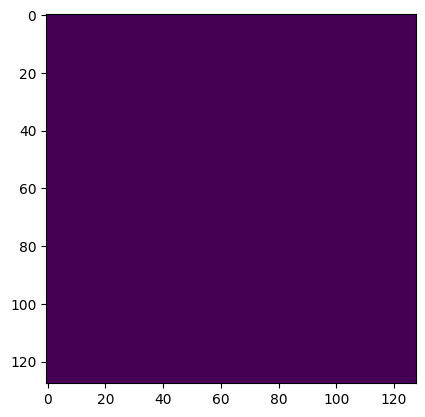

In [15]:
# print(train_tiles.shape)
# print(train_labels.shape)


# pix_t = np.sum(train_labels == True)
# pix_f = np.sum(train_labels == False)
# print(pix_t)
# print(pix_f)
# print(pix_t + pix_f)
# print(609*300*300)

# plt.imshow(train_labels[123])
# # plt.imshow(train_tiles[123])

In [14]:
'''Define the model and train'''
model = get_model(train_tiles[0].shape)
# model.summary()
tf.keras.utils.plot_model(model, 'model_summary.png', show_shapes=True, show_layer_names=False, expand_nested=True, show_layer_activations = True)

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# Training the model
model.fit(train_tiles, train_labels, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=0.2)

2023-05-15 09:06:02.719295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 09:06:02.734059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 09:06:02.736805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 09:06:02.742571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2023-05-15 09:06:06.048709: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 184483840 exceeds 10% of free system memory.
2023-05-15 09:06:06.253664: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 46120960 exceeds 10% of free system memory.
2023-05-15 09:06:06.329399: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 184483840 exceeds 10% of free system memory.
2023-05-15 09:06:06.464408: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 46120960 exceeds 10% of free system memory.


Epoch 1/20


2023-05-15 09:06:12.561002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-05-15 09:06:21.845589: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f088843f6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-15 09:06:21.845634: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-15 09:06:21.898943: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-15 09:06:24.066974: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.7395

2023-05-15 09:06:46.735969: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 46137344 exceeds 10% of free system memory.


176/176 [==============================] - 42s 101ms/step - loss: 0.6736 - accuracy: 0.7395 - val_loss: 0.4548 - val_accuracy: 0.8476
Epoch 2/20
176/176 [==============================] - 15s 87ms/step - loss: 0.5624 - accuracy: 0.7552 - val_loss: 0.5330 - val_accuracy: 0.8531
Epoch 3/20
176/176 [==============================] - 16s 89ms/step - loss: 0.5528 - accuracy: 0.7564 - val_loss: 0.5173 - val_accuracy: 0.8531
Epoch 4/20
176/176 [==============================] - 16s 89ms/step - loss: 0.5459 - accuracy: 0.7569 - val_loss: 0.4532 - val_accuracy: 0.8192
Epoch 5/20
176/176 [==============================] - 16s 88ms/step - loss: 0.5291 - accuracy: 0.7640 - val_loss: 0.7332 - val_accuracy: 0.5790
Epoch 6/20
176/176 [==============================] - 16s 90ms/step - loss: 0.4720 - accuracy: 0.7941 - val_loss: 0.5210 - val_accuracy: 0.8151
Epoch 7/20
176/176 [==============================] - 16s 89ms/step - loss: 0.3697 - accuracy: 0.8450 - val_loss: 0.4923 - val_accuracy: 0.8347
Ep

In [15]:
'''IMPORTANT: save the model'''
model.save(f'./working/2d_unet_frag_{fragment}_slice_{slice_idx}_epo_{EPOCH}_b_{BATCH_SIZE}_tile_{TILE_SIZE}_stri_{STRIDE}.h5')


## Evaluating

In [16]:
# get test set
test_tiles = all_test_tiles[:, 0, :, :]
test_labels = all_test_labels[:, :, :]

# Expand dimensions to add a channel dimension (grayscale)
test_tiles = np.expand_dims(test_tiles, axis=-1)
test_labels = np.expand_dims(test_labels, axis=-1)


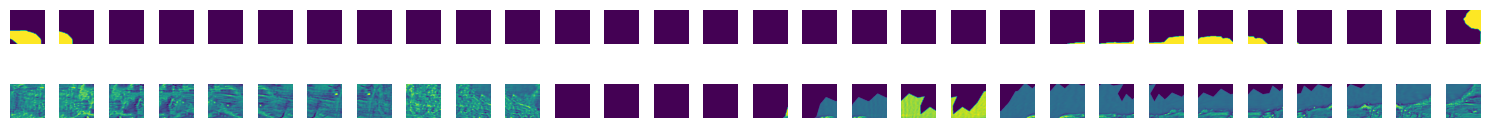

In [17]:
idx_test = np.arange(30,60)

fig, axes = plt.subplots(2,30,figsize=(15,2))
for c,i in enumerate(idx_test):
    axes[0,c].imshow(test_labels[i])
# for c,i in enumerate(idx_test):
#     axes[1,c].imshow(test_labels[i])

for c,i in enumerate(idx_test):
    axes[1,c].imshow(test_tiles[i])

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
'''evaluate the model on the test set'''

# Load the saved model
# model = load_model('/kaggle/working/2d_unet_frag_1_slice_3_epo_10_b_16_tile_64_stri_32.h5')


loss, accuracy = model.evaluate(test_tiles, test_labels)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get predictions for test data
predictions = model.predict(test_tiles)

44/44 [==============================] - 4s 69ms/step - loss: 1.3305 - accuracy: 0.7115
Test Loss: 1.3304800987243652
Test Accuracy: 0.7115498781204224
44/44 [==============================] - 3s 52ms/step


In [54]:
# '''evaluate the model on the train set'''

# # Load the saved model
# # model = load_model('/kaggle/working/2d_unet_frag_1_slice_3_epo_10_b_16_tile_64_stri_32.h5')


# loss, accuracy = model.evaluate(train_tiles, train_labels)

# print("train Loss:", loss)
# print("train Accuracy:", accuracy)

# # Get predictions for test data
# predictions = model.predict(train_tiles)

110/110 [==============================] - 4s 36ms/step - loss: 0.3186 - accuracy: 0.9488
train Loss: 0.3186436891555786
train Accuracy: 0.9487913846969604
110/110 [==============================] - 4s 32ms/step


In [19]:
# convert predictions to binary masks by thresholding
binary_predictions = (predictions > 0.3).astype(np.uint8)

# Access an individual prediction
prediction_index = 0  # Index of the specific test image to retrieve its prediction
prediction = binary_predictions[prediction_index]

# Alternatively, access the original predicted probabilities
probability_prediction = predictions[prediction_index]

(20, 128, 128)
(20, 128, 128)
(20, 128, 128)


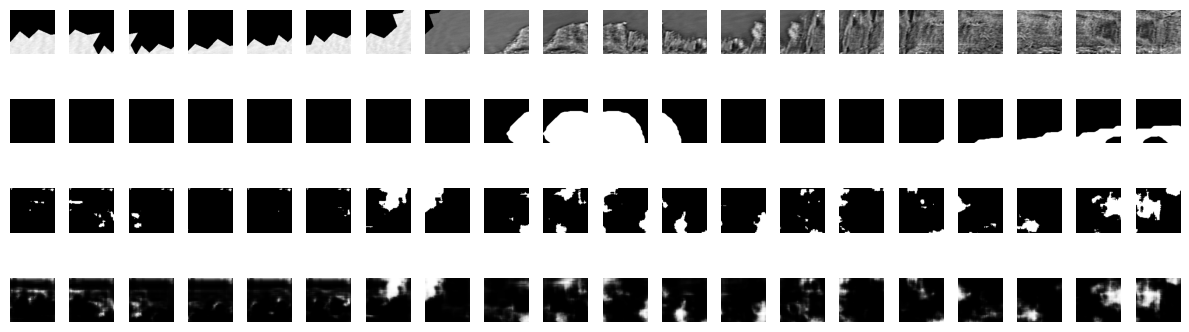

In [20]:
# Plot the original test image, label, and prediction
sample_idx = np.arange(10,30)  # Index of the specific test sample to visualize
fig, axes = plt.subplots(4, 20, figsize=(12, 4))

# Plot the original test image
for c,i in enumerate(sample_idx):
    axes[0,c].imshow(test_tiles[i, :, :, 0], cmap='gray')
#     axes[0,c].set_title('Original Image')

# Plot the ground truth label
for c,i in enumerate(sample_idx):
    axes[1,c].imshow(test_labels[i, :, :, 0], cmap='gray')
#     axes[1,c].set_title('Ground Truth Label')

print(test_tiles[sample_idx, :, :, 0].shape)
print(test_labels[sample_idx, :, :, 0].shape)
print(binary_predictions[sample_idx, :, :, 0].shape)
# Plot the predicted segmentation mask
for c,i in enumerate(sample_idx):
    axes[2,c].imshow(binary_predictions[i, :, :, 0], cmap='gray')
#     axes[2,c].set_title('Predicted Mask')

# Plot the predicted segmentation mask
for c,i in enumerate(sample_idx):
    axes[3,c].imshow(predictions[i, :, :, 0], cmap='gray')
#     axes[3,c].set_title('Predicted Mask')
    
for ax in axes.flat:
    ax.axis('off')
    

# Adjust spacing between subplots and display the plot
plt.tight_layout()
plt.savefig('predictions.svg')
plt.show()

(20, 128, 128)
(20, 128, 128)
(20, 128, 128)


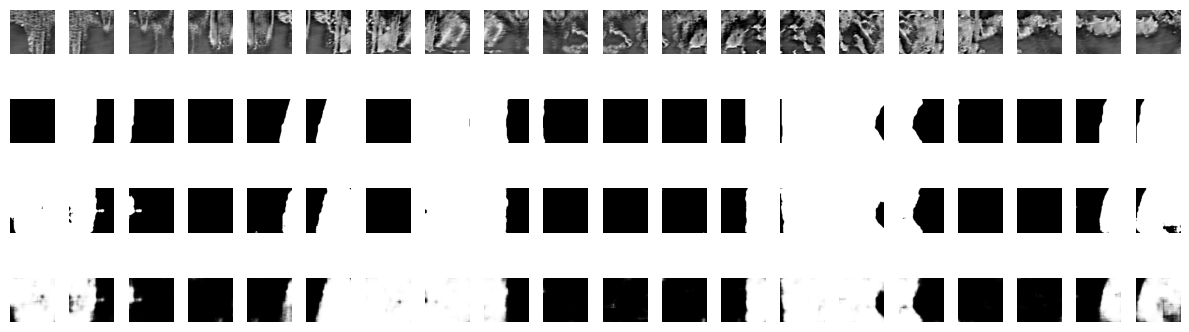

In [56]:
# # Plot the original test image, label, and prediction
# sample_idx = np.arange(10,30)  # Index of the specific test sample to visualize
# fig, axes = plt.subplots(4, 20, figsize=(12, 4))

# # Plot the original test image
# for c,i in enumerate(sample_idx):
#     axes[0,c].imshow(train_tiles[i, :, :, 0], cmap='gray')
# #     axes[0,c].set_title('Original Image')

# # Plot the ground truth label
# for c,i in enumerate(sample_idx):
#     axes[1,c].imshow(train_labels[i, :, :, 0], cmap='gray')
# #     axes[1,c].set_title('Ground Truth Label')

# print(test_tiles[sample_idx, :, :, 0].shape)
# print(test_labels[sample_idx, :, :, 0].shape)
# print(binary_predictions[sample_idx, :, :, 0].shape)
# # Plot the predicted segmentation mask
# for c,i in enumerate(sample_idx):
#     axes[2,c].imshow(binary_predictions[i, :, :, 0], cmap='gray')
# #     axes[2,c].set_title('Predicted Mask')

# # Plot the predicted segmentation mask
# for c,i in enumerate(sample_idx):
#     axes[3,c].imshow(predictions[i, :, :, 0], cmap='gray')
# #     axes[3,c].set_title('Predicted Mask')
    
# for ax in axes.flat:
#     ax.axis('off')
    

# # Adjust spacing between subplots and display the plot
# plt.tight_layout()
# plt.savefig('predictions.svg')
# plt.show()